In [149]:
import os
import sys
sys.path.append('../src/')
import glob
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 101)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import cca_functions

# configurations
- follow the file selection dialog:
    - select microscopy folder in first step
    - select positions of the selected folder in second step
- repeat to add more positions to the analysis
- positions selected within one iteration of the dialog will be pooled together in the following analyses

In [150]:
data_dirs, positions = cca_functions.configuration_dialog()
file_names = [os.path.split(path)[-1] for path in data_dirs]
image_folders = [[os.path.join(data_dir, pos_str, 'Images') for pos_str in pos_list] for pos_list, data_dir in zip(positions, data_dirs)]
# determine available channels based on first(!) position.
# Warn user if one or more of the channels are not available for some positions
first_pos_files = os.listdir(os.path.join(data_dirs[0], positions[0][0], 'Images'))
channels, warn = cca_functions.find_available_channels(first_pos_files)

# load data and perform all needed calculations on image data

In [151]:
overall_df = cca_functions.calculate_downstream_data(file_names, image_folders, positions, channels)

Load files for MIA_KC_test_files, Position_2...
Number of cells in position: 18
Number of annotated frames in position: 241
Cell Cycle property data already existing, loaded from disk...
Load files for MIA_KC_test_files, Position_3...
Number of cells in position: 28
Number of annotated frames in position: 241
Cell Cycle property data already existing, loaded from disk...
Load files for MIA_KC_test_files, Position_4...
Number of cells in position: 54
Number of annotated frames in position: 241
Cell Cycle property data already existing, loaded from disk...
Load files for MIA_KC_test_files, Position_5...
Number of cells in position: 42
Number of annotated frames in position: 208
Cell Cycle property data already existing, loaded from disk...
Load files for MIA_KC_test_files_flu_control, Position_1...
Number of cells in position: 65
Number of annotated frames in position: 241
Cell Cycle property data already existing, loaded from disk...
Load files for MIA_KC_test_files_flu_control, Positio

In [152]:
overall_df.head()

,frame_i,Cell_ID,is_cell_dead,is_cell_excluded,x_centroid,y_centroid,editIDclicked_x,editIDclicked_y,editIDnewID,cell_cycle_stage,generation_num,relative_ID,relationship,emerg_frame_i,division_frame_i,is_history_known,corrected_assignment,cell_area_pxl,cell_vol_vox,cell_area_um2,cell_vol_fl,area,convex_area,filled_area,major_axis_length,minor_axis_length,orientation,perimeter,centroid_y,centroid_x,solidity,2d_label_count,min_t,max_t,lifespan,age,frames_till_gone,elongation,mCitrine_corrected_mean_signal,phase_contr_corrected_mean_signal,max_frame_pos,file,selection_subset,position,directory,mCitrine_corrected_signal_amount,phase_contr_corrected_signal_amount,daughter_area
0,0,1,False,False,135,67,NaN,NaN,-1,S,2,2,mother,-1,-1,False,False,603,10292.289,31.072,120.390,603,618,603,30.092,25.540,0.766,90.083,67.146,135.453,0.976,1.0,0,240,241,1,240,1.178,838.257,134.604,240,MIA_KC_test_files,0,Position_2,C:/Users/mairhoermann/Documents/phd-code/Yeast...,505469.0,81166.0,74.0
1,0,2,False,False,152,61,NaN,NaN,-1,S,0,1,bud,-1,-1,False,False,74,453.764,3.813,5.308,74,75,74,10.045,9.437,-0.624,29.556,61.000,152.270,0.987,1.0,0,32,33,1,32,1.064,NaN,NaN,240,MIA_KC_test_files,0,Position_2,C:/Users/mairhoermann/Documents/phd-code/Yeast...,NaN,NaN,0.0
2,1,1,False,False,135,66,NaN,NaN,-1,S,2,2,mother,-1,-1,False,False,612,10444.698,31.536,122.173,612,622,612,30.470,25.584,0.720,89.841,66.724,135.221,0.984,1.0,0,240,241,2,239,1.191,847.786,154.234,240,MIA_KC_test_files,0,Position_2,C:/Users/mairhoermann/Documents/phd-code/Yeast...,518845.0,94391.0,75.0
3,1,2,False,False,152,60,NaN,NaN,-1,S,0,1,bud,-1,-1,False,False,75,456.054,3.865,5.335,75,78,75,10.354,9.257,-0.531,30.142,60.333,152.080,0.962,1.0,0,32,33,2,31,1.118,27.320,-16.867,240,MIA_KC_test_files,0,Position_2,C:/Users/mairhoermann/Documents/phd-code/Yeast...,2049.0,-1265.0,0.0
4,2,1,False,False,135,66,NaN,NaN,-1,S,2,2,mother,-1,-1,False,False,636,11165.316,32.772,130.602,636,653,636,30.776,26.355,0.710,93.255,66.998,135.208,0.974,1.0,0,240,241,3,238,1.168,835.858,184.635,240,MIA_KC_test_files,0,Position_2,C:/Users/mairhoermann/Documents/phd-code/Yeast...,531606.0,117428.0,69.0


In [153]:
# build dataframe grouped by phases
phase_grouped = overall_df.sort_values(
    'frame_i'
).groupby(
    ['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'file']
).agg(
    growth_in_phase=('area', lambda x: max(x)-min(x)),
    phase_length=('frame_i', lambda x: max(x)-min(x)),
    area_at_beginning=('area', lambda x: x.iloc[0]),
    daughter_growth=('daughter_area', lambda x: max(x)-min(x)),
    phase_begin = ('frame_i', min),
    phase_end = ('frame_i', max),
    max_frame_pos = ('max_frame_pos', 'first'),
    selection_subset = ('selection_subset', 'first'),
    cell_max_t = ('max_t', 'first'),
    mCitrine_at_beginning = ('mCitrine_corrected_signal_amount', 'first'),
    mCitrine_mean_at_beginning = ('mCitrine_corrected_mean_signal', 'first')
).reset_index()

# detect incomplete cell cycle stages and incomplete cell cycles
temp = np.logical_or(
    phase_grouped.phase_begin == 0,
    phase_grouped.phase_end == phase_grouped.max_frame_pos
)
incomplete_phase_indices = np.logical_or(
    temp,
    phase_grouped.phase_end == phase_grouped.cell_max_t
)
no_of_phases_per_cycle = phase_grouped.groupby(
    ['Cell_ID', 'generation_num', 'position', 'file']
)['cell_cycle_stage'].transform('count')
incomplete_cycle_indices = no_of_phases_per_cycle < 2
phase_grouped['incomplete_phase'] = incomplete_phase_indices.astype(int)
phase_grouped['incomplete_cycle'] = incomplete_cycle_indices.astype(int)
phase_grouped['all_complete'] = np.logical_and(~incomplete_phase_indices, ~incomplete_cycle_indices).astype(int)

In [154]:
phase_grouped.sort_values(['file', 'position', 'Cell_ID', 'generation_num']).head(15)

,Cell_ID,generation_num,cell_cycle_stage,position,file,growth_in_phase,phase_length,area_at_beginning,daughter_growth,phase_begin,phase_end,max_frame_pos,selection_subset,cell_max_t,mCitrine_at_beginning,mCitrine_mean_at_beginning,incomplete_phase,incomplete_cycle,all_complete
6,1,2,S,Position_2,MIA_KC_test_files,52,25,603,272.0,0,25,240,0,240,505469.0,838.257,1,1,0
12,1,3,G1,Position_2,MIA_KC_test_files,158,14,628,400.0,26,40,240,0,240,348895.0,555.565,0,0,1
18,1,3,S,Position_2,MIA_KC_test_files,199,31,765,365.0,41,72,240,0,240,362238.0,473.514,0,0,1
24,1,4,G1,Position_2,MIA_KC_test_files,124,6,784,31.0,73,79,240,0,240,311457.0,397.267,0,0,1
30,1,4,S,Position_2,MIA_KC_test_files,103,27,789,454.0,80,107,240,0,240,351093.0,444.985,0,0,1
36,1,5,G1,Position_2,MIA_KC_test_files,97,6,742,39.0,108,114,240,0,240,288783.0,389.195,0,0,1
42,1,5,S,Position_2,MIA_KC_test_files,58,28,726,425.0,115,143,240,0,240,283158.0,390.025,0,0,1
48,1,6,G1,Position_2,MIA_KC_test_files,46,11,774,466.0,144,155,240,0,240,247022.0,319.150,0,0,1
54,1,6,S,Position_2,MIA_KC_test_files,83,42,790,640.0,156,198,240,0,240,284142.0,359.673,0,0,1
59,1,7,G1,Position_2,MIA_KC_test_files,63,16,736,91.0,199,215,240,0,240,225767.0,306.749,0,0,1


# generate plots / analyses on obtained data

## growth in G1 vs. mother+daughter growth in S (1st generation)

Text(0.5, 1.0, 'G1 growth vs. mother+daughter cell S growth')

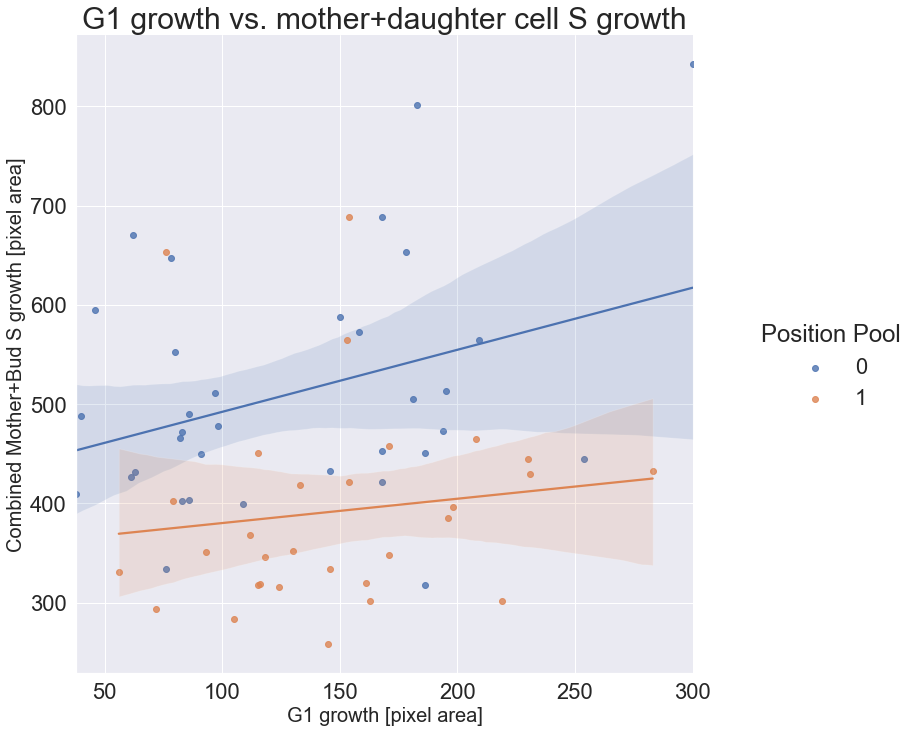

In [33]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data2 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position'], how='inner')
plot_data2 = plot_data2[plot_data2.generation_num==1]
plot_data2['combined_motherbud_growth'] = plot_data2['growth_in_phase_y'] + plot_data2['daughter_growth_y']

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="growth_in_phase_x", y="combined_motherbud_growth", data=plot_data2,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Combined Mother+Bud S growth [pixel area]", fontsize=20)
ax.set_xlabel("G1 growth [pixel area]", fontsize=20)
ax.set_title("G1 growth vs. mother+daughter cell S growth", fontsize=30)

## Size at birth vs. G1 growth (1st generation)

Text(0.5, 1.0, 'Size at birth vs G1 duration (1st generation)')

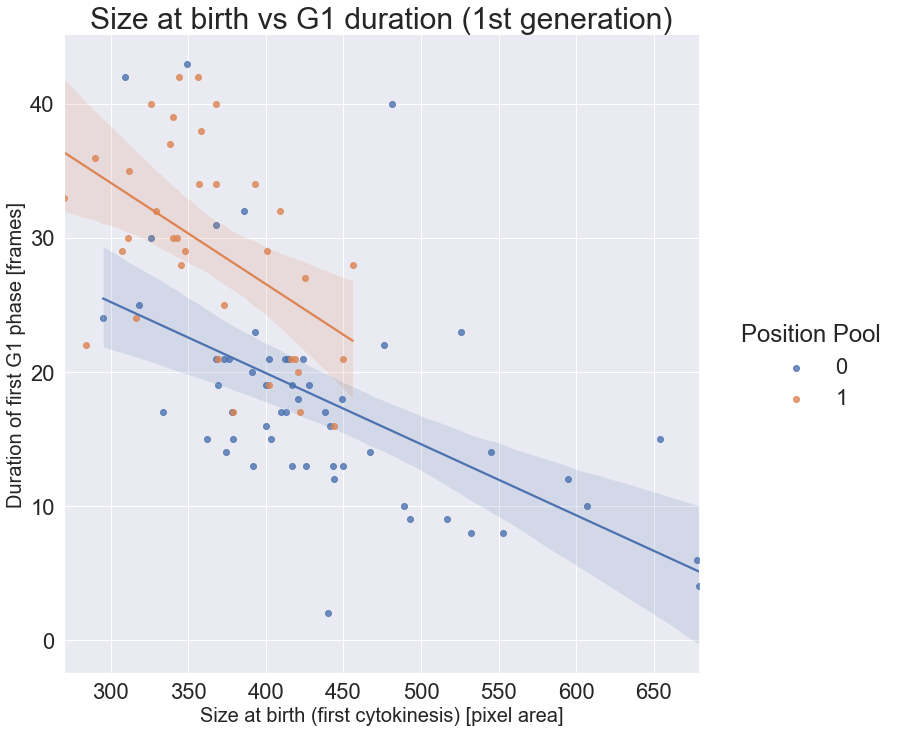

In [34]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data3 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data3 = plot_data3[plot_data3.incomplete_phase==0]
plot_data3 = plot_data3[plot_data3.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="area_at_beginning", y="phase_length", data=plot_data3,
    hue="selection_subset", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Duration of first G1 phase [frames]", fontsize=20)
ax.set_xlabel("Size at birth (first cytokinesis) [pixel area]", fontsize=20)
ax.set_title("Size at birth vs G1 duration (1st generation)", fontsize=30)

## Size at birth vs. mCitrine amount at birth (1st generation)

Text(0.5, 1.0, 'Size at birth vs mCitrine amount (1st generation)')

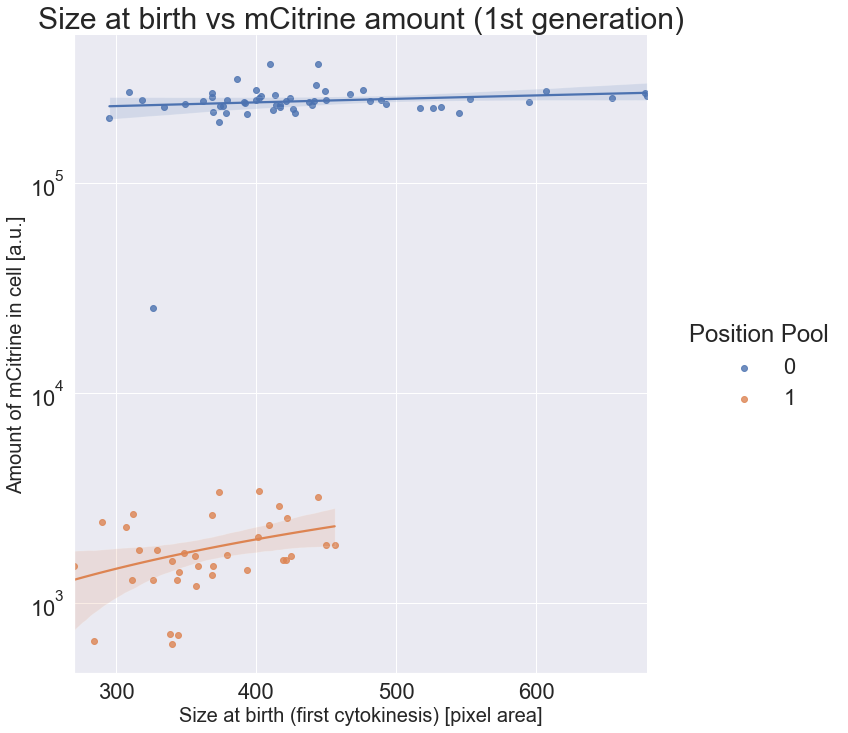

In [145]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data4 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data4 = plot_data4[plot_data4.incomplete_phase==0]
plot_data4 = plot_data4[plot_data4.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="area_at_beginning", y="mCitrine_at_beginning", data=plot_data4,
    hue="selection_subset", height=10, )
g._legend.set_title('Position Pool')
g.set(yscale="log")
ax = plt.gca()
ax.set_ylabel("Amount of mCitrine in cell [a.u.]", fontsize=20)
ax.set_xlabel("Size at birth (first cytokinesis) [pixel area]", fontsize=20)
ax.set_title("Size at birth vs mCitrine amount (1st generation)", fontsize=30)

## Size at birth vs. mCitrine mean (~concentration?) at birth (1st generation)

Text(0.5, 1.0, 'Size at birth vs mean mCitrine (concentration, 1st generation)')

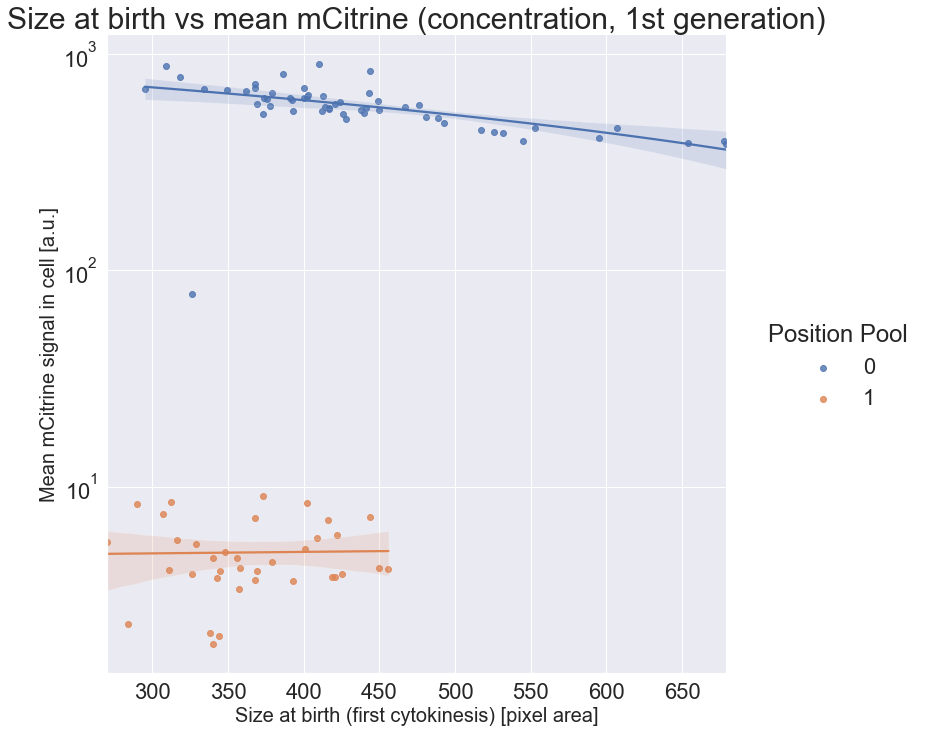

In [148]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data4 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data4 = plot_data4[plot_data4.incomplete_phase==0]
plot_data4 = plot_data4[plot_data4.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="area_at_beginning", y="mCitrine_mean_at_beginning", data=plot_data4,
    hue="selection_subset", height=10, )
g._legend.set_title('Position Pool')
g.set(yscale="log")
ax = plt.gca()
ax.set_ylabel("Mean mCitrine signal in cell [a.u.]", fontsize=20)
ax.set_xlabel("Size at birth (first cytokinesis) [pixel area]", fontsize=20)
ax.set_title("Size at birth vs mean mCitrine (concentration, 1st generation)", fontsize=30)

## Flurescence Signal over time

In [164]:
needed_cols = [
    'selection_subset', 'position', 'Cell_ID', 'cell_cycle_stage', 'generation_num', 'frame_i',
    'mCitrine_corrected_mean_signal', 'mCitrine_corrected_signal_amount', 'file', 'relationship'
]
plot_data5 = overall_df[needed_cols].copy()
plot_data5['frames_in_phase'] = plot_data5.sort_values(['frame_i'], ascending=True)\
             .groupby(['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'file', 'selection_subset'])\
             .cumcount() + 1

phase_lengths = plot_data5.groupby(
    ['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'selection_subset']
).agg(phase_length=('frame_i', lambda x: max(x)-min(x)+1)).reset_index()
plot_data5 = plot_data5.merge(
    phase_lengths, 
    on=['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'selection_subset'],
    how='left'
)
plot_data5['relative_time_in_phase'] = plot_data5['frames_in_phase']/plot_data5['phase_length']
plot_data5['Pool, Phase, Type'] = plot_data5.apply(
    lambda x: f'Pool {str(x.loc["selection_subset"])}, Phase {x.loc["cell_cycle_stage"]}, Type {x.loc["relationship"]}', axis=1
)

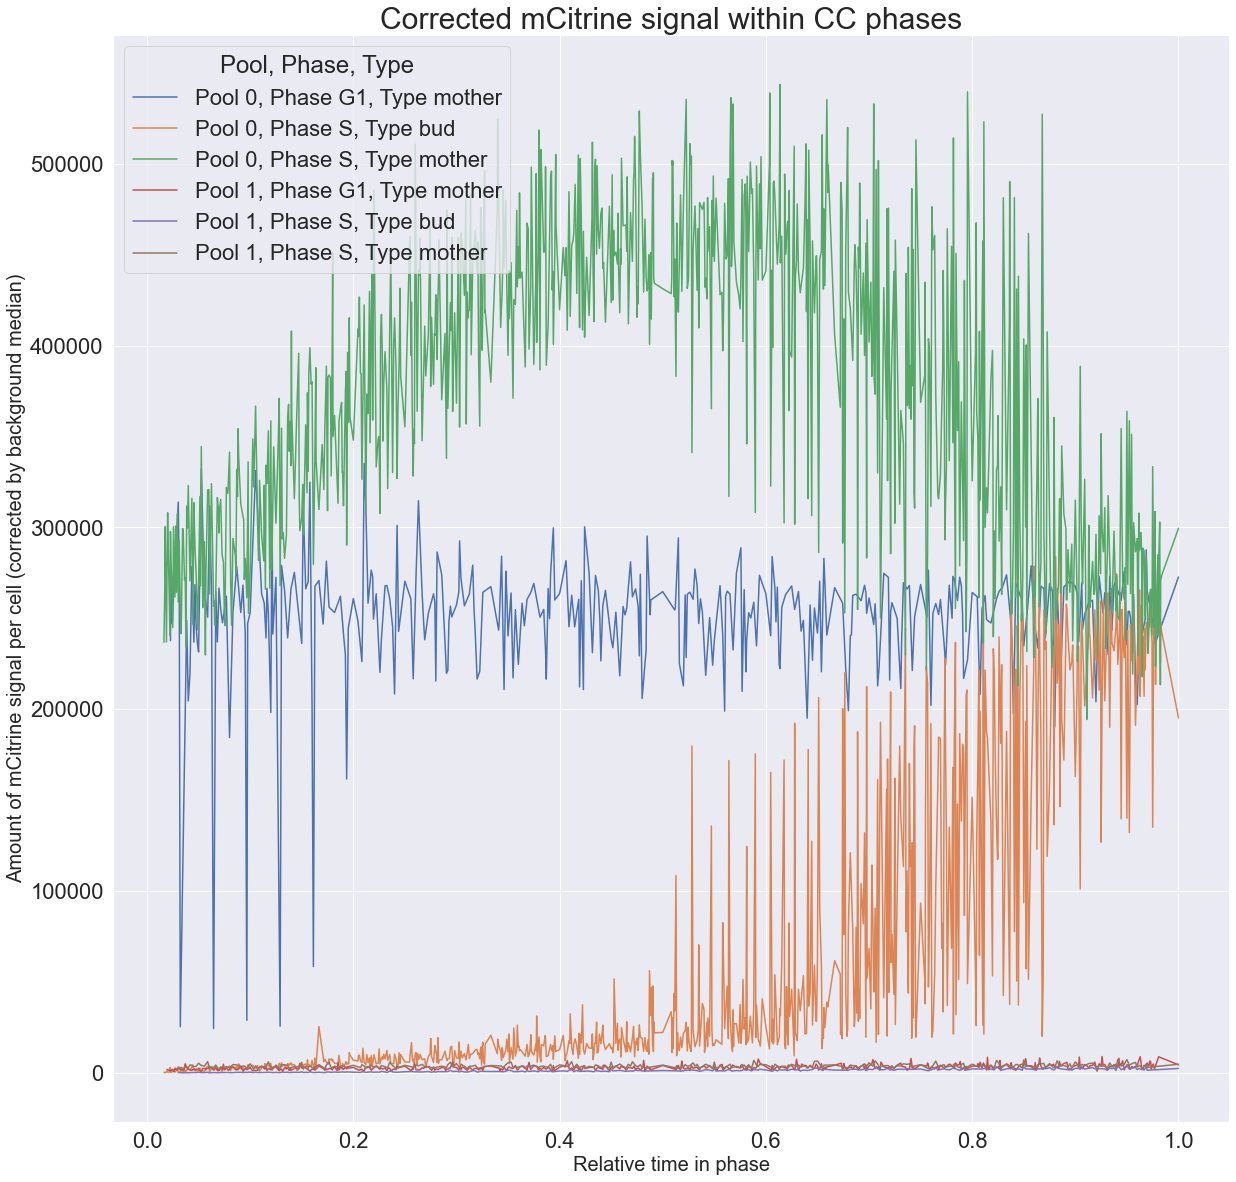

In [165]:
sns.set_theme(style="darkgrid", font_scale=2)
f, ax = plt.subplots(figsize=(20, 20))
sns.lineplot(data=plot_data5.sort_values('Pool, Phase, Type'), x="relative_time_in_phase", y="mCitrine_corrected_signal_amount", 
             hue='Pool, Phase, Type', ci=None)
ax.set_ylabel("Amount of mCitrine signal per cell (corrected by background median)", fontsize=20)
ax.set_xlabel("Relative time in phase", fontsize=20)
ax.set_title("Corrected mCitrine signal within CC phases", fontsize=30)
plt.show()

## Flurescence Signal over time (centered on bud emergence)

In [174]:
# select needed cols from overall_df to not end up with too many columns
needed_cols = [
    'selection_subset', 'position', 'Cell_ID', 'cell_cycle_stage', 'generation_num', 'frame_i',
    'mCitrine_corrected_mean_signal', 'mCitrine_corrected_signal_amount', 'file', 'relationship',
    'relative_ID'
]
ov_copy = overall_df[needed_cols].copy()
# merge cells with their relatives to calculate combined amounts of mCitrine
merged = ov_copy.merge(
    ov_copy, 
    how='inner',
    left_on=['frame_i', 'file', 'position', 'relative_ID'],
    right_on=['frame_i', 'file', 'position', 'Cell_ID']
)
# calculate the length of the current phase for every line in the dataframe
phase_lengths = merged.groupby(
    ['Cell_ID_x', 'generation_num_x', 'cell_cycle_stage_x', 'position', 'selection_subset_x']
).agg(phase_length=('frame_i', lambda x: max(x)-min(x)+1)).reset_index()
merged = merged.merge(
    phase_lengths, 
    on=['Cell_ID_x', 'generation_num_x', 'cell_cycle_stage_x', 'position', 'selection_subset_x'],
    how='left'
)
# calculate the time the cell already spent in the current frame at the current timepoint
merged['frames_in_phase'] = merged.sort_values(['frame_i'], ascending=True)\
             .groupby(['Cell_ID_x', 'generation_num_x', 'cell_cycle_stage_x', 'position',
                       'file', 'selection_subset_x']).cumcount() + 1
# calculate the time to the next (for G1 cells) and from the last (for S cells) G1/S transition  
merged['centered_frames_in_phase'] = merged.apply(
    lambda x: x.loc['frames_in_phase'] if\
    x.loc['cell_cycle_stage_x']=='S' else\
    x.loc['frames_in_phase']-x.loc['phase_length'],
    axis=1
)
# calculate combined signal and the "Pool, Phase ID" for the legend
merged['combined_signal'] = merged.apply(
    lambda x: x.loc['mCitrine_corrected_signal_amount_x']+x.loc['mCitrine_corrected_signal_amount_y'] if\
    x.loc['cell_cycle_stage_x']=='S' and x.loc['relationship_x'] == 'mother' else\
    x.loc['mCitrine_corrected_signal_amount_x'],
    axis=1
)
plot_data6 = merged[merged.relationship_x=='mother'].copy()
plot_data6['Pool, Phase'] = plot_data6.apply(
    lambda x: f'Pool {str(x.loc["selection_subset_x"])}, Phase {x.loc["cell_cycle_stage_x"]}', axis=1
)

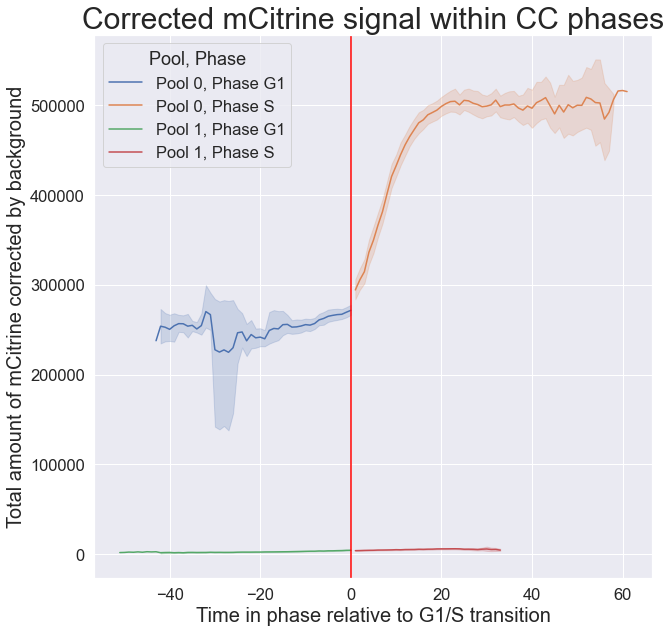

In [225]:
# plot the data
sns.set_theme(style="darkgrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=plot_data6.sort_values('Pool, Phase'), x="centered_frames_in_phase", y="combined_signal", 
             hue='Pool, Phase')
ax.axvline(x=0, color='red')
ax.set_ylabel("Total amount of mCitrine corrected by background", fontsize=20)
ax.set_xlabel("Time in phase relative to G1/S transition", fontsize=20)
ax.set_title("Corrected mCitrine signal within CC phases", fontsize=30)
plt.show()

## G1 vs. S duration (1st generation)

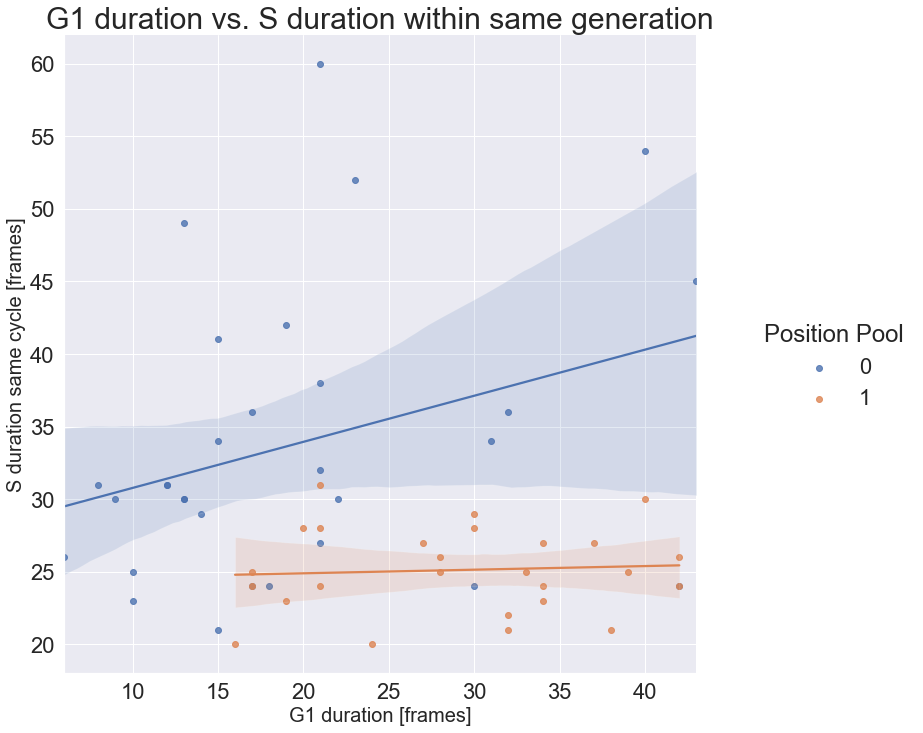

In [29]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data1 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position', 'file'], how='inner')
plot_data1 = plot_data1[plot_data1.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="phase_length_x", y="phase_length_y", data=plot_data1,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("S duration same cycle [frames]", fontsize=20)
ax.set_xlabel("G1 duration [frames]", fontsize=20)
ax.set_title("G1 duration vs. S duration within same generation", fontsize=30)
plt.show()

# backup

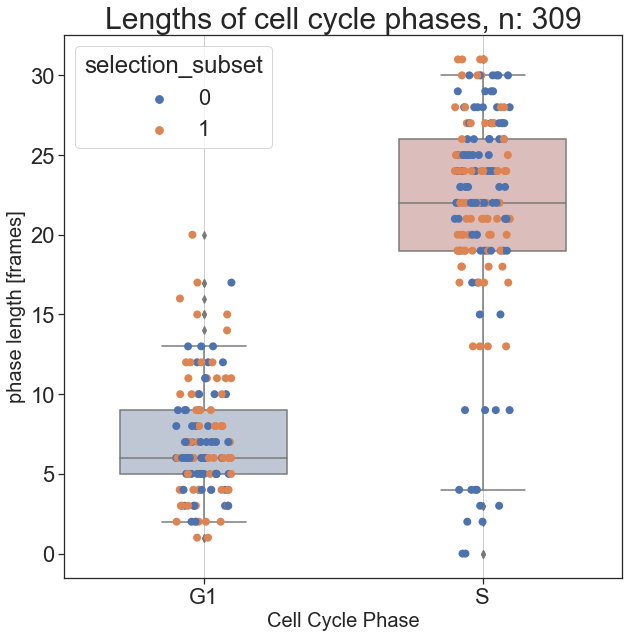

In [69]:
plot_data1 = phase_grouped[~incomplete_phase_indices]
sns.set_theme(style="ticks", font_scale=2)

# Initialize the figure
f, ax = plt.subplots(figsize=(10, 10))
# Plot the orbital period with horizontal boxes
sns.boxplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
            whis=[5, 95], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
              size=8, hue="selection_subset", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set_ylabel("phase length [frames]", fontsize=20)
ax.set_xlabel("Cell Cycle Phase", fontsize=20)
ax.set_title(f"Lengths of cell cycle phases, n: {plot_data1.shape[0]}", fontsize=30)
#sns.despine(trim=True, left=True)
plt.show()

In [144]:
# code for calculating column "phase transition (boolean)"
"""
plot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)

plot_data3['phase_transition'] = 0
for i in plot_data3.cell_pos_id.unique():
    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]
    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)
    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1
    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data
"""

"\nplot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)\n\nplot_data3['phase_transition'] = 0\nfor i in plot_data3.cell_pos_id.unique():\n    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]\n    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)\n    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1\n    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data\n"

### alternatively configure stuff manually

In [24]:
# the path to the data folder containing the MIA_ folders
data_dir = os.path.join('..', 'data', 'nd2_files')
# the MIA_ folder which should be analyzed
mia_dir = 'MIA_F016.nd2'
# the positions which should be incorporated in the analysis
positions = [6]
# channels to incorporate in the Analysis, assuming to be the same for all positions
channels = ['phase_contr', 'mCitrine']